# What is the most optimal skill to learn for Data Analysts
### Methodology
1. Group skills to determine median salary and likelihood of being in posting
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

## Importing Libraries and Loading Data

In [2]:
#Importing Libraries
import ast
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])  # converting job_posted_date to datetime object
df['job_skills'] = df['job_skills'].apply(lambda data: ast.literal_eval(data) if pd.notna(data) else data)  # converting job_skills to list

## Clean Data

In [13]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()  # filter for Data Analysts jobs in US 

In [14]:
# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

# explode job_skills column to create new row for each skill associated with job
df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


## Calculate the Percentage of Job Postings with Skills

In [20]:
# group data by job_skills and calculate count and median salary for each skill, sort the results by count
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

# rename columns names for clarity
df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

# find count of Data Analyst jobs for US with salary info
DA_job_count = len(df_DA_US)

# create new column with skill percentage
df_DA_skills['skill_percentage'] = df_DA_skills['skill_count'] / DA_job_count * 100

skill_percentage = 5

# limit the results to data with skill percentage over 5
df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percentage'] > skill_percentage]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percentage
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


## Median Salary vs Percent Skill Demand

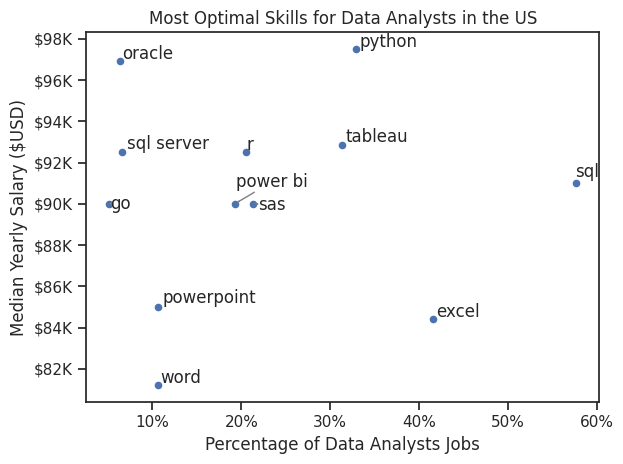

In [40]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

# create scatter plot
df_DA_skills_high_demand.plot(kind='scatter', x='skill_percentage', y='median_salary')

# add labels to points and collect them in the list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percentage'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=1))

# format current axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y / 1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.xlabel('Percentage of Data Analysts Jobs')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title(f'Most Optimal Skills for Data Analysts in the US')
plt.tight_layout()
plt.show()

## Color by Technology

In [31]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [32]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

# explode skills column and create multiple rows for each technology
df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,microstrategy
0,analyst_tools,looker
0,analyst_tools,ms access
0,analyst_tools,powerbi
0,analyst_tools,powerpoint
...,...,...
9,sync,zoom
9,sync,webex
9,sync,unify
9,sync,mattermost


In [33]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percentage,technology,skills
0,2508,91000.0,57.655172,programming,sql
1,1808,84392.0,41.563218,analyst_tools,excel
2,1431,97500.0,32.896552,programming,python
3,1364,92875.0,31.356322,analyst_tools,tableau
4,926,90000.0,21.287356,analyst_tools,sas
...,...,...,...,...,...
169,1,100000.0,0.022989,libraries,theano
170,1,65000.0,0.022989,programming,typescript
171,1,147500.0,0.022989,cloud,vmware
172,1,65000.0,0.022989,webframeworks,vue


In [36]:
# filter to select rows where percentage columns is greater than 5
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percentage'] > skill_percentage]

## Final Plot

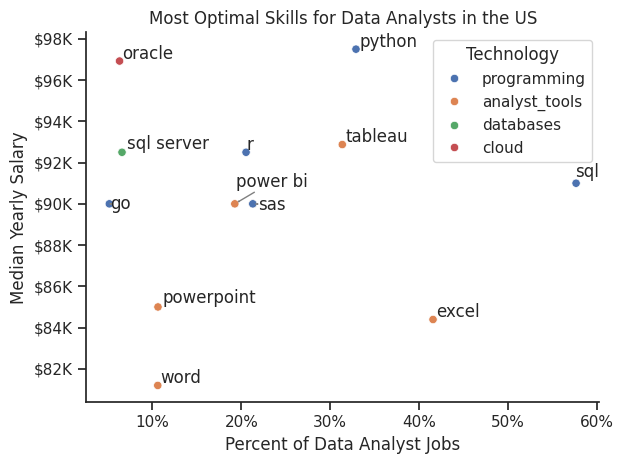

In [41]:
# create scatter plot using seaborn
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percentage',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percentage'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

plt.tight_layout()
plt.show()